# Catch Basin Classifier

Some initial setup code: 

In [20]:
import tensorflow as tf

image_size = (534, 716)

## Load and Prepare Data 

Load the data and split into two groups: *training* and *validation*

In [14]:
training_dataset = tf.keras.utils.image_dataset_from_directory("data", validation_split=0.7, subset="training", seed=123, image_size=image_size)
validation_dataset = tf.keras.utils.image_dataset_from_directory("data", validation_split=0.3, subset="validation", seed=123, image_size=image_size)

# Get list of classnames to verify that the class names were interpreted correctly
training_dataset.class_names

Found 8 files belonging to 3 classes.
Using 3 files for training.
Found 8 files belonging to 3 classes.
Using 2 files for validation.


['blocked', 'clear', 'partial']

## Construction of the Model

In [22]:
from tensorflow.keras.models import Sequential
from keras import layers

model = Sequential([
    layers.Rescaling(1./255, input_shape=(*image_size, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 534, 716, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 534, 716, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 267, 358, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 267, 358, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 133, 179, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 133, 179, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 66, 89, 64)       

## Training

In [24]:
epochs = 10

history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 5.6580e-05 - accuracy: 1.0000 - val_loss: 52.6655 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 964ms/step - loss: 1.5895e-07 - accuracy: 1.0000 - val_loss: 51.4621 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 1s 981ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 50.4396 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 1s 957ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 49.5850 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 49.8725 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 1s 939ms/step - loss: 1.2318e-06 - accuracy: 1.0000 - val_loss: 52.7327 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 1s 891ms/step - loss: 1.0906e-04 - accuracy: 1.0000 - val_loss

## Training Analysis

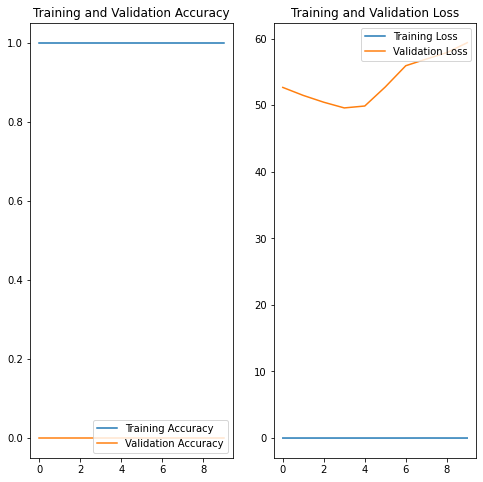

In [26]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

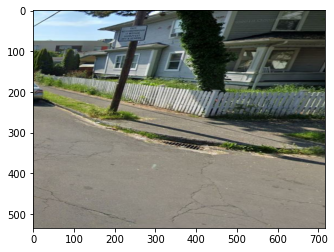

In [49]:
import keras
import numpy as np

img_tensor = next(iter(validation_dataset))[0]
img_tensor /= 255
plt.imshow(img_tensor[0])

10
(2, 534, 716, 3)
11
[[ 1.2931732  2.64235   -1.4667643]
 [ 1.2945876  2.638954  -1.4664073]]


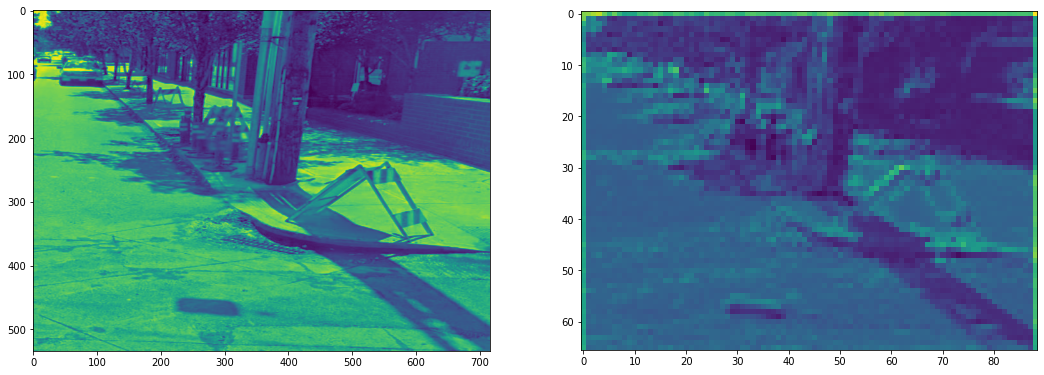

In [140]:
activation_model = keras.models.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])
activations = activation_model.predict(img_tensor)

print(len(activations))
print(activations[0].shape)
print(len(activation_model.layers))

print(activations[9])

plt.figure(figsize=(18,18))
plt.subplot(1, 2, 1)
plt.imshow(next(iter(validation_dataset))[0][1, :, :, 2])
plt.subplot(1, 2, 2)
plt.imshow(activations[6][1, :, :, 2])